In [5]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pickle
import import_ipynb # so vectorize_PCA.ipynb can be imported
from PCA_heatmap_bin_cells_filtered import get_X_labels_lens, biplot, scree_plot
from clustering import evaluate_performance, plot_evaluation_scores
from sklearn.cluster import KMeans, SpectralClustering
import time

my_filepath_chr_filtered = "/Users/kinichen/UTSSRP/Tuzhilina_Project/UTSSRP-github/contact_dict_bin_cells_chr_filtered.pkl"

In [7]:
if __name__ == "__main__":	# don't run if imported
	with open(my_filepath_chr_filtered, "rb") as f:
		dict_chr = pickle.load(f)

In [8]:
# Get new information
X_fil, cell_labels_fil, labels_fil, chr_lens_fil = get_X_labels_lens(dict_chr)
print("X chromosome filtered shape:", X_fil.shape)
# everything UNfiltered: 2611 cell files, 236562 loci contact pairs
# cells and chr filtered: 1958 cell files, 139448 loci contact pairs


KeyboardInterrupt



Explained variance ratio: [0.01404503 0.00623001]
X shape: (1958, 139448)
X_pca shape: (1958, 139448)
Loadings shape: (139448, 2)
Labels: {'GM12878', 'Hela', 'K562', 'HAP1'}


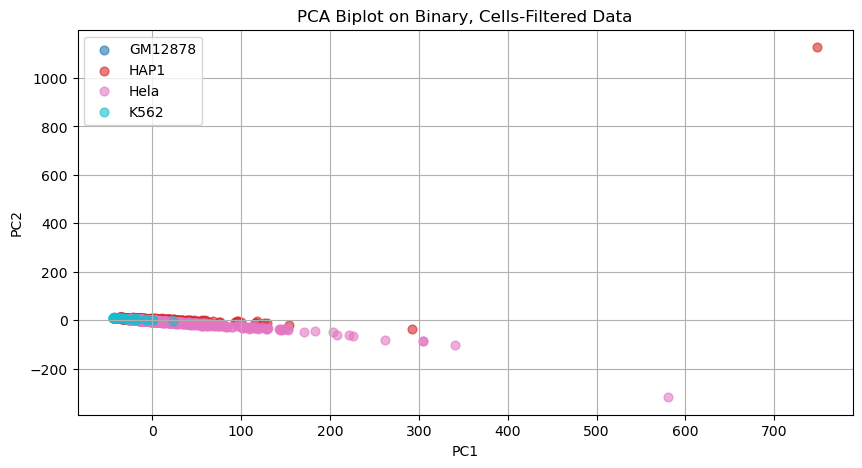

In [4]:
# For biplot visualization

# Perform PCA, keeping only top 2 components
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_fil)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

loadings = pca.components_.T       # shape = (n_features, 2)
explained_var = pca.explained_variance_ratio_
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")


# Build feature_names, so can interpret key features from biplot
# Each feature (column of X) represents a (chromosome, locus_i, locus_j) pair.
# E.g. feature_names[i] = "chr3:42-47" means the ith feature corresponds to the
# contact between locus 42 and locus 47 on chromosome 3 (only intrachromosomal contacts)
feature_names = []
chromosomes = [f"chr{i+1}" for i in range(len(chr_lens_fil))]

k = 1 # set to 0 if want to include block diagonals
for chr_idx, chr_len in enumerate(chr_lens_fil):
	for i in range(chr_len):
		for j in range(i + k, chr_len):
			feature_names.append(f"{chromosomes[chr_idx]}:{i}-{j}")

	
# check
assert len(feature_names) == X_fil.shape[1], "Mismatch: feature_names do not align with X columns"

print("X shape:", X_fil.shape)
print("X_pca shape:", X_fil.shape)
print("Loadings shape:", loadings.shape)
print("Labels:", set(labels_fil))

biplot(X_pca, loadings, labels=labels_fil, chr_fil=True, feature_names=None, top_features=0)

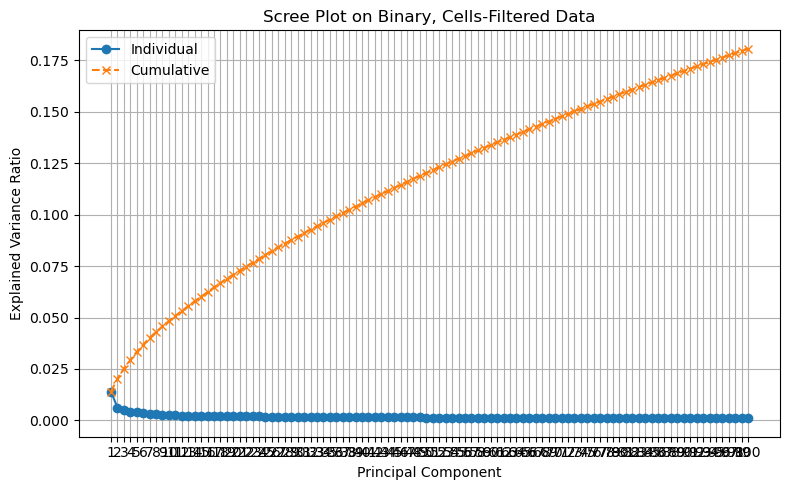

In [5]:
# Scree plot
scree_plot(X_fil)

In [6]:
# For clustering, keep more components
pca = PCA(n_components=300)	
X_pca = pca.fit_transform(X_fil)

In [7]:
# KMeans

num_clusters = len(np.unique(labels_fil))
kmeans = KMeans(init="random", n_clusters=num_clusters, 
				random_state=0, n_init=10)
labels_pred = kmeans.fit_predict(X_pca)


# evaluate clustering performance 
true_type_labels = labels_fil
evaluate_performance(true_type_labels, labels_pred, X_reduced=X_pca)

Kmeans ARI score: 0.09
Normalized Mutual Information (NMI): 0.11
Kmeans Silhouette Score: 0.05


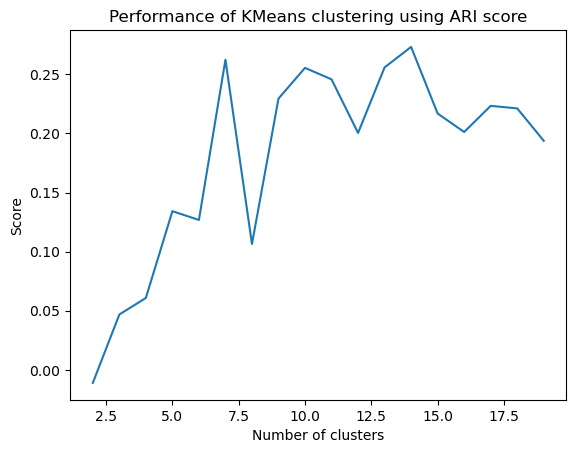

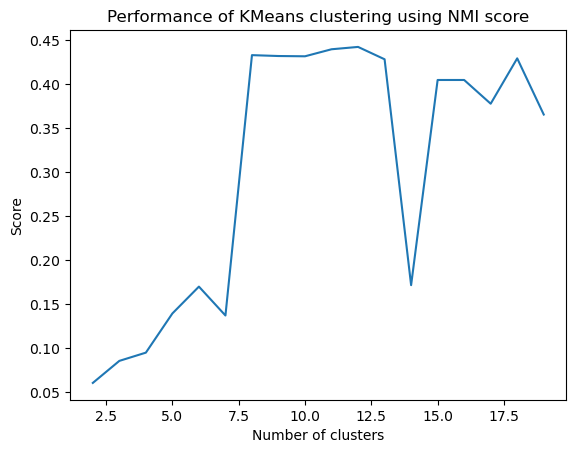

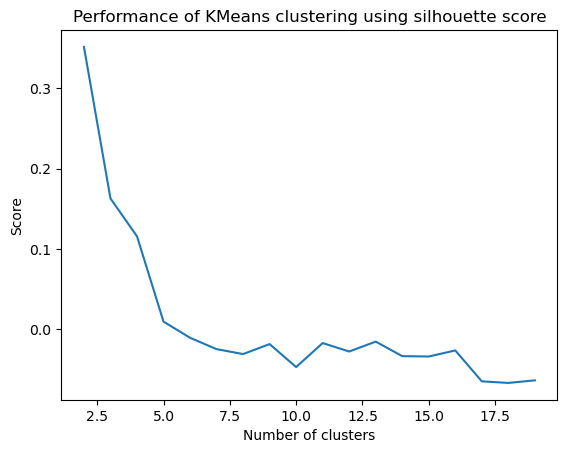

In [8]:
# Visualizing metrics for each number of clusters choice
true_type_labels = labels_fil
plot_evaluation_scores(X=X_pca, y=true_type_labels, n_clusters_range=range(2, 20), metric="ARI")
plot_evaluation_scores(X=X_pca, y=true_type_labels, n_clusters_range=range(2, 20), metric="NMI")
plot_evaluation_scores(X=X_pca, y=true_type_labels, n_clusters_range=range(2, 20), metric="silhouette")

In [9]:
# Spectral

spectral = SpectralClustering(
	n_clusters=num_clusters,
	affinity='nearest_neighbors',  # or 'rbf' or 'precomputed'
	n_neighbors=10,
	assign_labels='kmeans',
	random_state=42			# seed for reproducibility
)

labels_pred = spectral.fit_predict(X_pca)
evaluate_performance(true_type_labels, labels_pred, X_reduced=X_pca)

Kmeans ARI score: 0.43
Normalized Mutual Information (NMI): 0.51
Kmeans Silhouette Score: -0.09


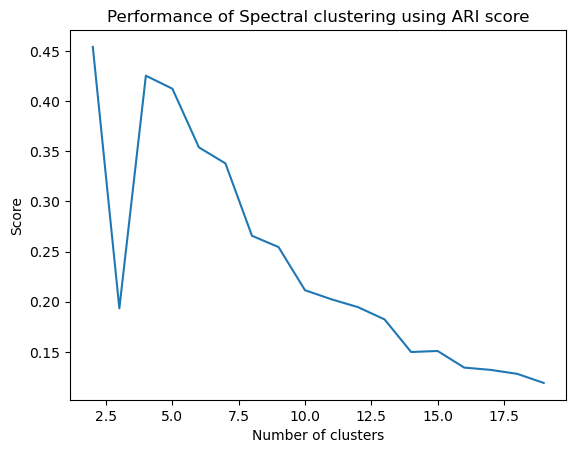

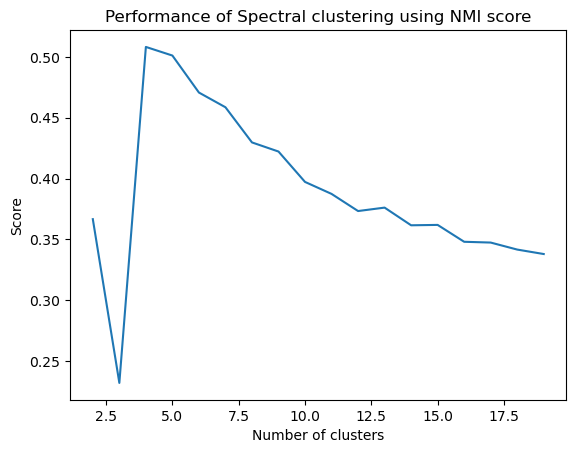

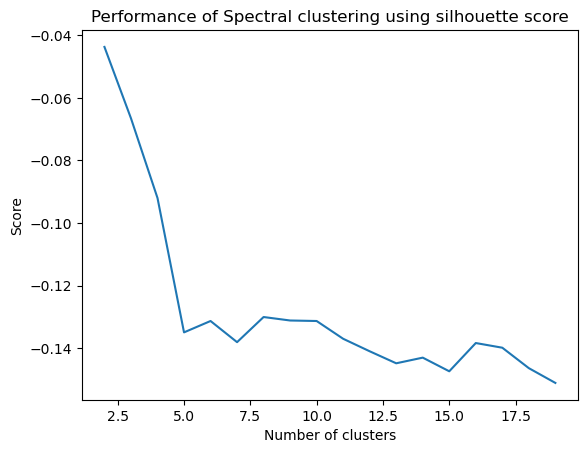

In [10]:
plot_evaluation_scores(X_pca, true_type_labels, n_clusters_range=range(2, 20), metric="ARI", method="Spectral")
plot_evaluation_scores(X_pca, true_type_labels, n_clusters_range=range(2, 20), metric="NMI", method="Spectral")
plot_evaluation_scores(X_pca, true_type_labels, n_clusters_range=range(2, 20), metric="silhouette", method="Spectral")

In [6]:
# Check computation time of PCA with data with all chromosomes
if __name__ == "__main__":
	start_time = time.time()

	with open(my_filepath_chr_filtered, "rb") as f:
		contact_dict = pickle.load(f)
  
	X, cell_labels, labels, chr_lens = get_X_labels_lens(contact_dict)
	print("X shape:", X.shape)
	X = X.astype(np.float32) # halve memory space

	# Run PCA
	pca_filtered = PCA(n_components=300)
	X_pca_filtered = pca_filtered.fit_transform(X)

	end_time = time.time()
	print(f"Time with filtering chromosomes: {end_time - start_time:.2f} seconds")

X shape: (1958, 139448)
Time without filtering chromosomes: 109.60 seconds
